# For testing purpose we run a custom CNN model. 

In [1]:
import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import math


dir_list = [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

for classes in dir_list:
    src_path = '/kaggle/input/sugarcane-leaf-akash/Sugarcane Leaf Image Dataset/All Classes/' + classes
    dst_path = '/kaggle/working/temp/' + classes + '/' + classes
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
    
for classes in dir_list:
    
    kaggle_input_dir = '/kaggle/working/temp/' + classes

    temp_dir = '/kaggle/working/augment/' + classes

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    generated_images = datagen.flow_from_directory(
        kaggle_input_dir,
        save_to_dir=temp_dir,
        batch_size = 1,
        save_prefix=classes,
        save_format='jpg'
    )

    num_images = max(700, min(700, len(generated_images)))
    for i in range(num_images):
        generated_image = next(generated_images)



# Define dataset paths
dataset_path = '/kaggle/working/augment'
categories = os.listdir(dataset_path)
num_classes = len(categories)

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data()

# Ensure that we have loaded images
if len(images) == 0:
    raise Exception("No images loaded. Check dataset path and image files.")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

print("Data loading and preprocessing completed successfully.")



def create_custom_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Fully Connected Layer
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
custom_cnn_model = create_custom_cnn(input_shape=(224, 224, 3), num_classes=num_classes)

# Learning rate decay function
def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)

# Define callbacks
callbacks = [
    ModelCheckpoint('custom_cnn_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1),
    lr_scheduler,
    reduce_lr
]

print ("Done")

2024-05-29 18:52:39.430108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 18:52:39.430197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 18:52:39.585364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 471 images belonging to 1 classes.
Found 1722 images belonging to 1 classes.
Found 314 images belonging to 1 classes.
Found 343 images belonging to 1 classes.
Found 346 images belonging to 1 classes.
Found 430 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 652 images belonging to 1 classes.
Found 663 images belonging to 1 classes.
Found 1194 images belonging to 1 classes.
Found 316 images belonging to 1 classes.
Data loading and preprocessing completed successfully.
Done


In [2]:
# Train the model
history = custom_cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)

# Evaluate the model
scores = custom_cnn_model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {scores[0]}, Validation Accuracy: {scores[1]}')

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/193 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.1094 - loss: 4.4791   

I0000 00:00:1717008987.074433     185 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717008987.095007     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/193 ━━━━━━━━━━━━━━━━━━━━ 3:25 1s/step - accuracy: 0.2093 - loss: 3.7415 

W0000 00:00:1717009003.184046     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3263 - loss: 2.4709

W0000 00:00:1717009062.671987     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717009064.713361     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/193 ━━━━━━━━━━━━━━━━━━━━ 101s 413ms/step - accuracy: 0.3266 - loss: 2.4688 - val_accuracy: 0.1019 - val_loss: 16.4265 - learning_rate: 0.0010
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 67s 337ms/step - accuracy: 0.4594 - loss: 1.6201 - val_accuracy: 0.1474 - val_loss: 5.7016 - learning_rate: 0.0010
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 67s 335ms/step - accuracy: 0.5358 - loss: 1.3934 - val_accuracy: 0.4766 - val_loss: 2.2132 - learning_rate: 0.0010
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 68s 338ms/step - accuracy: 0.5776 - loss: 1.1822 - val_accuracy: 0.5474 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 5/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 66s 332ms/step - accuracy: 0.6090 - loss: 1.1228 - val_accuracy: 0.0909 - val_loss: 14.3959 - learning_rate: 0.0010
Epoch 6/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 65s 322ms/step - accuracy: 0.5921 - loss: 1.1450 - val_accuracy: 0.2630 - val_loss: 3.7168 - learning_rate: 0.0010
Epoch 7/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 65s 324ms/step - accuracy: 0.6027 - lo

13/49 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1717009600.692175     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


W0000 00:00:1717009601.785405     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


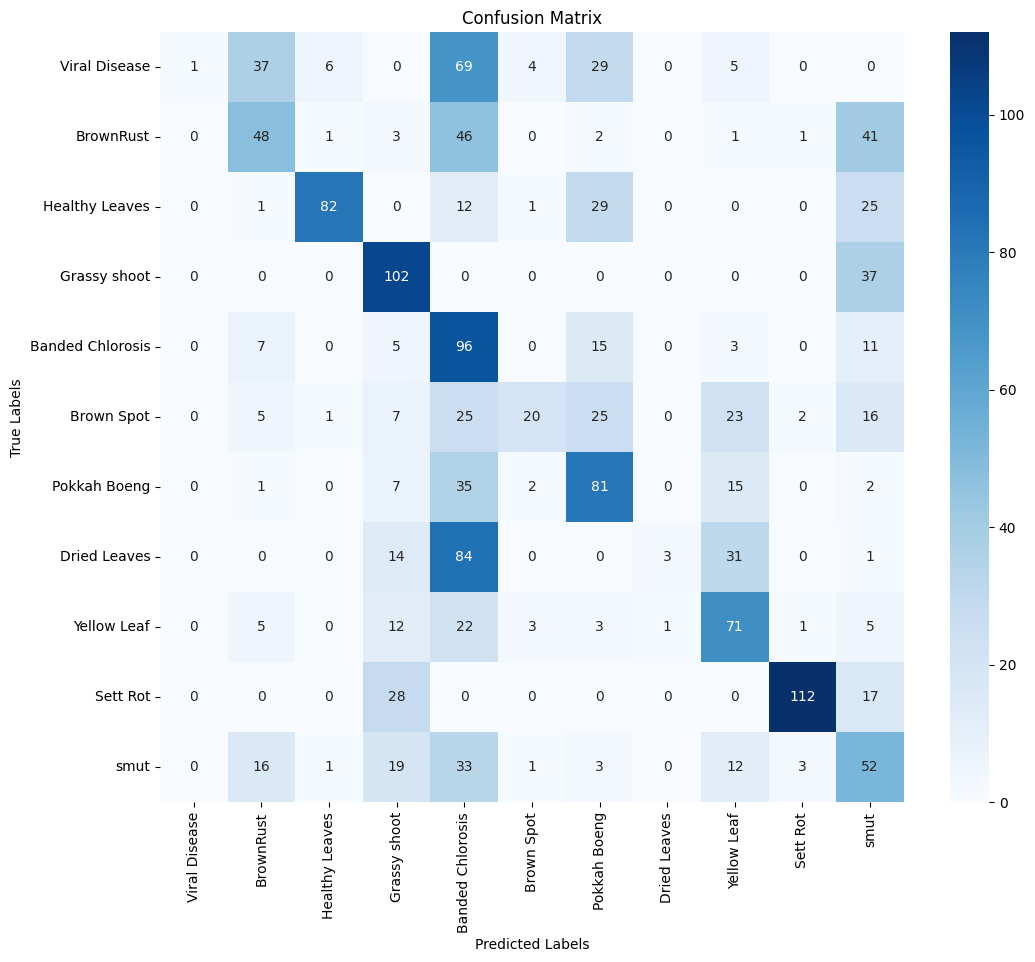

In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict classes for validation set
y_val_pred_prob = custom_cnn_model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Convert one-hot encoded labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


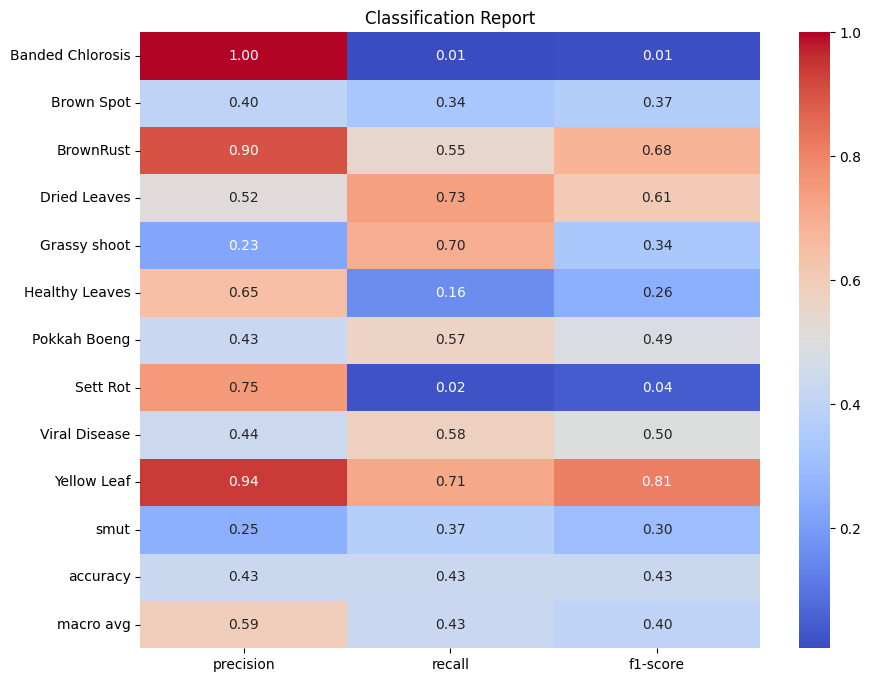

In [4]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation set
y_val_pred = custom_cnn_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


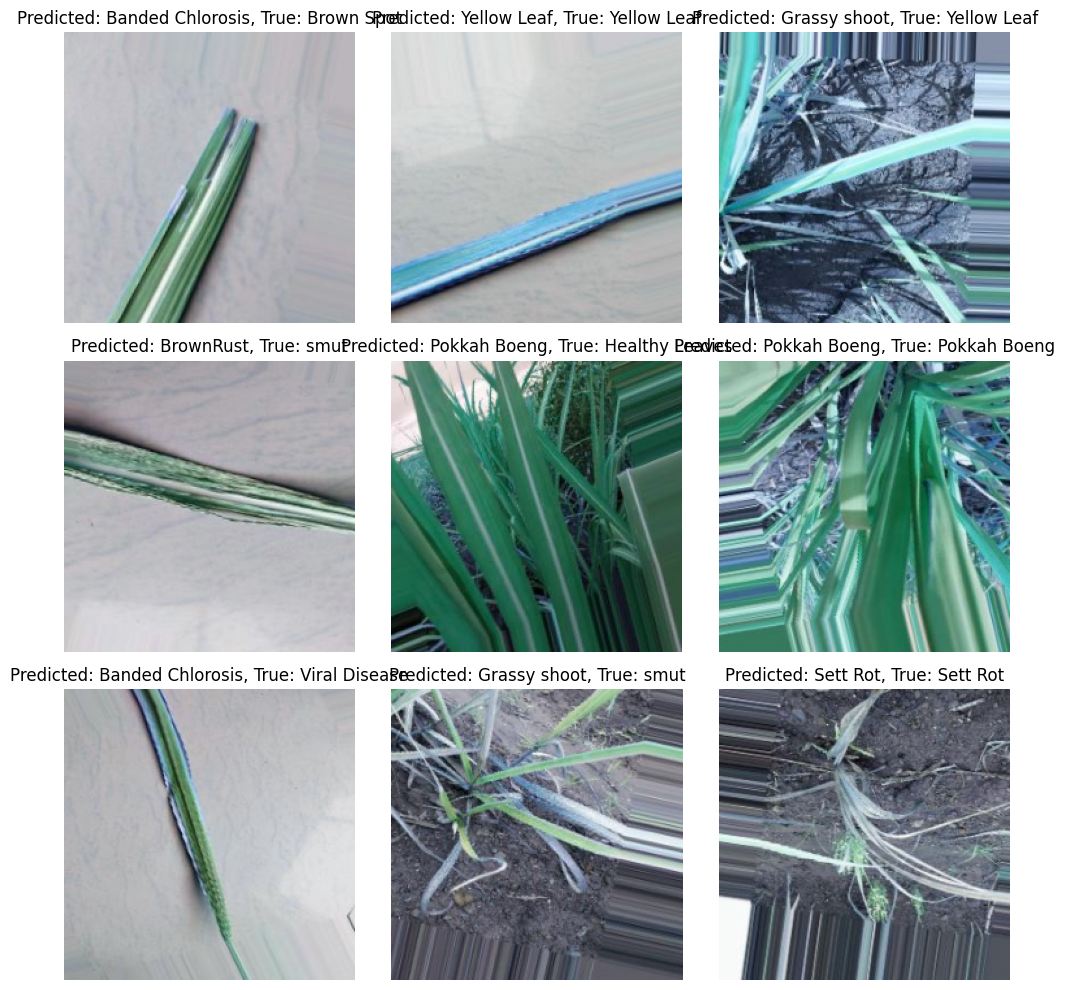

In [5]:
import matplotlib.pyplot as plt
import numpy as np



y_val_pred_prob = custom_cnn_model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)


class_names = categories  


def plot_predictions(X, y_true, y_pred, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(f"Predicted: {class_names[y_pred[i]]}, True: {class_names[y_true[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 9 pic: 
plot_predictions(X_val, y_val_true, y_val_pred, class_names, num_images=9)


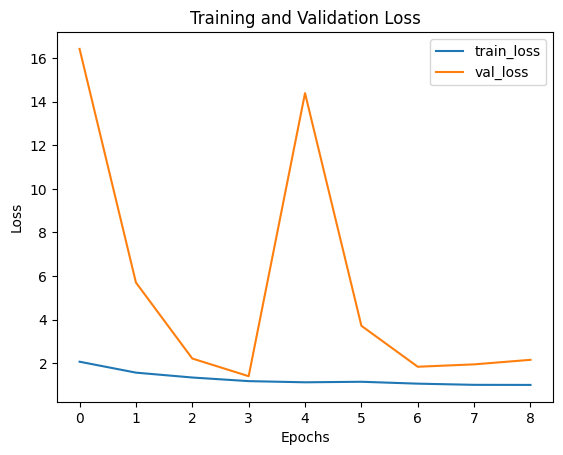

In [9]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

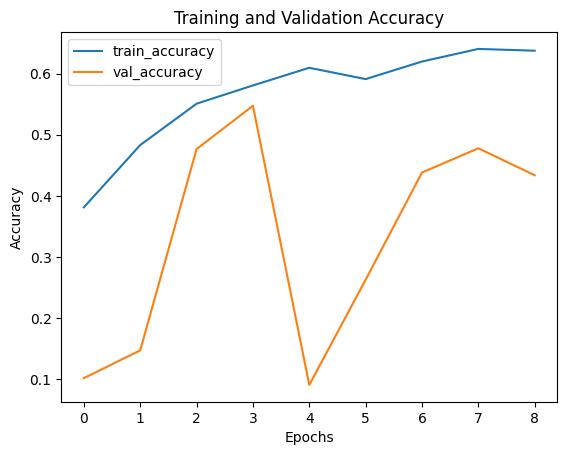

In [10]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()